In [38]:
import pandas as pd 
import numpy as np
from lightgbm import LGBMClassifier,plot_importance
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')

In [21]:
def make_folds(df):
    '''
    Function create Stratified K folds on the dataset
    Parameters
    ----------
    df : dataframe
    Returns
    -------
    dataframe
    '''
    
    df['kfold'] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    y = df.claim.values
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
        df.loc[v_,'kfold'] = f
        
    return df

In [22]:
df = make_folds(df)

In [23]:
models = {
    'lgbm':LGBMClassifier()
}

In [24]:
def run_folds(df,fold,model):
    '''
    Funtcion to train and predict on the models on the given fold
    Input : Dataframe,Integer,Model
    Output: NULL
    '''
    df_train = df[df.kfold!=fold].reset_index(drop=True)
    df_valid = df[df.kfold==fold].reset_index(drop=True)
    
    x_train = df_train.drop(columns=['claim','kfold','id'],axis=1).values
    y_train = df_train.claim.values
    
    x_valid = df_valid.drop(columns=['claim','kfold','id'],axis=1).values
    y_valid = df_valid.claim.values
    
    clf = models[model]
    
    clf.fit(x_train,y_train)
    train_preds = clf.predict_proba(x_train)[:,1]
    preds = clf.predict_proba(x_valid)[:,1]
    print(f'Fold{fold}')
    print('Train ROC_AUC:{}'.format(roc_auc_score(y_train, train_preds)))
    print('Validation ROC_AUC:{}'.format(roc_auc_score(y_valid, preds)))
    print('*'*50)
    
  #  joblib.dump(clf,f'models/dt_{fold}_{model}.bin')
    
    return

In [25]:
for i in range(5):
    run_folds(df,i,'lgbm')

Fold0
Train ROC_AUC:0.8071151734300938
Validation ROC_AUC:0.8013450969554666
**************************************************
Fold1
Train ROC_AUC:0.8072891409770199
Validation ROC_AUC:0.8014316641900607
**************************************************
Fold2
Train ROC_AUC:0.8071524675743232
Validation ROC_AUC:0.802422997065255
**************************************************
Fold3
Train ROC_AUC:0.807338201502468
Validation ROC_AUC:0.801240878829317
**************************************************
Fold4
Train ROC_AUC:0.8073634627513953
Validation ROC_AUC:0.8008977815414999
**************************************************


In [26]:
test = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')

In [27]:
test_df = test.drop(columns=['id'])

In [28]:
x_train = df.drop(columns=['id','claim','kfold']).values
y_train = df.claim.values
md = models['lgbm']
md.fit(x_train,y_train)

LGBMClassifier()

In [29]:
prediction = md.predict_proba(test_df)[:,1]

In [31]:
prediction = md.predict_proba(test_df)[:,1]
submission = pd.DataFrame({'id': test['id'],'claim': prediction})

In [33]:
submission.to_csv('submission.csv',index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

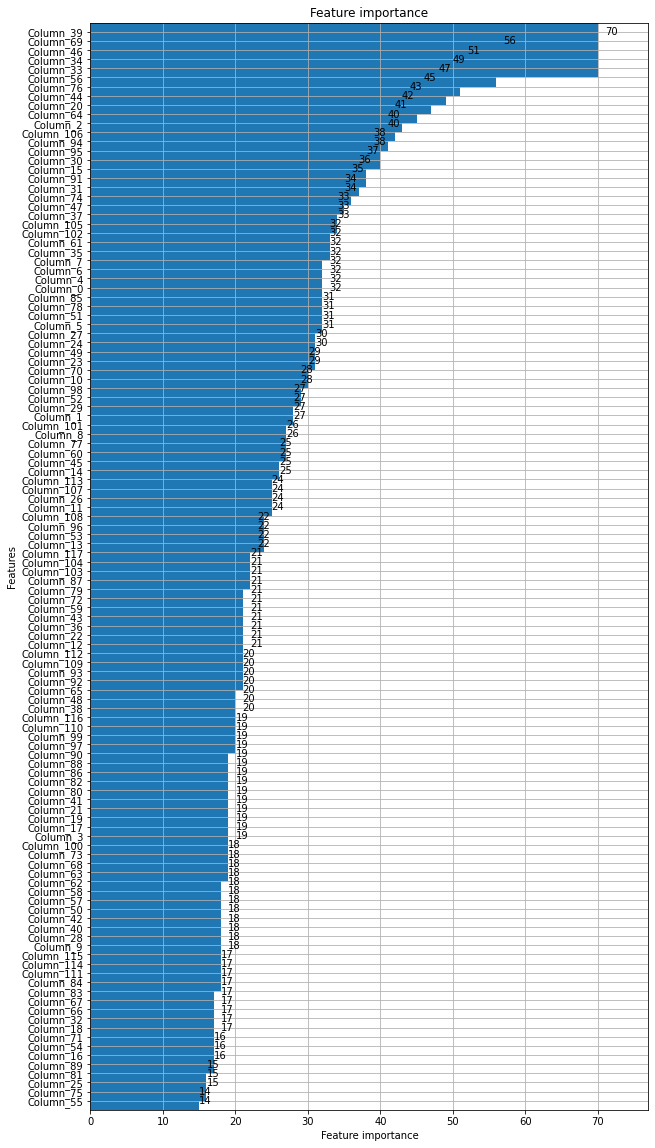

In [45]:
plot_importance(md,height=10,figsize=(10,20),)

In [51]:
 md.feature_importances_ 

array([32, 27, 40, 19, 32, 31, 32, 32, 26, 18, 28, 24, 21, 22, 25, 35, 16,
       19, 17, 19, 41, 19, 21, 29, 30, 15, 24, 30, 18, 27, 36, 34, 17, 47,
       49, 32, 21, 33, 20, 70, 18, 19, 18, 21, 42, 25, 51, 33, 20, 29, 18,
       31, 27, 22, 16, 14, 45, 18, 18, 21, 25, 32, 18, 18, 40, 20, 17, 17,
       18, 56, 28, 16, 21, 18, 33, 14, 43, 25, 31, 21, 19, 15, 19, 17, 17,
       31, 19, 21, 19, 15, 19, 34, 20, 20, 38, 37, 22, 19, 27, 19, 18, 26,
       32, 21, 21, 32, 38, 24, 22, 20, 19, 17, 20, 24, 17, 17, 19, 21],
      dtype=int32)

In [67]:
important_features = []
for i,score in enumerate(md.feature_importances_):
    if(score>10):
        important_features.append(f'f{i+1}')
    else:
        continue

In [68]:
train_df = pd.concat([df[important_features],df[['id','claim','kfold']]],axis=1)

In [69]:
for i in range(5):
    run_folds(train_df,i,'lgbm')

Fold0
Train ROC_AUC:0.7703865424906073
Validation ROC_AUC:0.762256490708821
**************************************************
Fold1
Train ROC_AUC:0.7701050522402403
Validation ROC_AUC:0.7629604168516589
**************************************************
Fold2
Train ROC_AUC:0.7698795298484098
Validation ROC_AUC:0.7645372382947201
**************************************************
Fold3
Train ROC_AUC:0.7705847405917745
Validation ROC_AUC:0.7625625121488964
**************************************************
Fold4
Train ROC_AUC:0.7704168006886335
Validation ROC_AUC:0.7621772881257842
**************************************************


In [72]:
features = df.drop(columns=['id','claim','kfold']).columns

In [74]:
for col in features:
    df[f'bin_10_{col}'] = pd.cut(df[col],bins=10,labels=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [78]:
for i in range(5):
    run_folds(df,i,'lgbm')

Fold0
Train ROC_AUC:0.8074030859437945
Validation ROC_AUC:0.8016878189326628
**************************************************
Fold1
Train ROC_AUC:0.8073605179601254
Validation ROC_AUC:0.8015460227651244
**************************************************
Fold2
Train ROC_AUC:0.8072366514996366
Validation ROC_AUC:0.8025534835410462
**************************************************
Fold3
Train ROC_AUC:0.8073939613727711
Validation ROC_AUC:0.8013104310687047
**************************************************
Fold4
Train ROC_AUC:0.8074787364559569
Validation ROC_AUC:0.8008968022400315
**************************************************


In [79]:
train_df = df[df['kfold']!=2].reset_index(drop=True)
x_train = train_df.drop(columns=['id','claim','kfold']).values
y_train = train_df.claim.values
md = models['lgbm']
md.fit(x_train,y_train)

LGBMClassifier()

In [81]:
for col in features:
    test_df[f'bin_10_{col}'] = pd.cut(test_df[col],bins=10,labels=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [83]:
prediction = md.predict_proba(test_df)[:,1]
submission = pd.DataFrame({'id': test['id'],'claim': prediction})

In [84]:
submission.to_csv('submission_2.csv',index=False)

In [87]:
pd.cut(df['f1'],bins=10,labels=False)

0         4.0
1         4.0
2         3.0
3         5.0
4         2.0
         ... 
957914    2.0
957915    4.0
957916    4.0
957917    4.0
957918    4.0
Name: f1, Length: 957919, dtype: float64

array([30, 27, 42, 15, 27, 30, 32, 39, 25, 26, 25, 23, 22, 21, 24, 35, 19,
       21, 19, 18, 34, 15, 21, 29, 25, 14, 22, 30, 17, 22, 32, 34, 17, 43,
       46, 29, 21, 26, 20, 62, 16, 18, 16, 20, 40, 28, 45, 34, 17, 28, 14,
       30, 27, 17, 18, 18, 44, 16, 13, 21, 23, 35, 18, 17, 37, 18, 18, 18,
       21, 48, 21, 19, 19, 16, 27, 15, 36, 23, 27, 11, 22, 15, 19, 17, 16,
       30, 19, 17, 17, 16, 20, 23, 18, 10, 37, 33, 22, 23, 29, 20, 16, 24,
       25, 17, 16, 22, 37, 23, 22, 19, 21, 16, 19, 15, 19, 18, 21, 18,  4,
        0,  0,  6,  1,  0,  6,  4,  2,  1,  1,  0,  2,  0,  0,  0,  3,  0,
        1,  0,  4,  7,  0,  2,  0,  0,  0,  2,  0,  3,  1,  1,  2,  0,  1,
        1,  0,  5,  5,  6,  0,  0,  4,  1,  0,  4,  2,  1,  3,  0,  1,  2,
        3,  0,  0,  0,  1,  2,  0,  0,  0,  0,  0,  1,  2,  0,  0,  1,  0,
        4,  7,  0,  0,  0,  0,  1,  1,  2,  1,  8,  0,  3,  0,  0,  0,  1,
        1,  0,  0,  2,  0, 11,  0, 10,  3,  2,  0,  0,  0,  0,  0,  0,  0,
        6,  0,  6,  0,  0